# ДЗ №3. Кредитные рейтинги

## Пункт 1. Построим распределение допустивших и недопустивших дефолт заемщиков по рейтинговым категориям

In [5]:
# 1) Откроем Anaconda Prompt и исполним следующее: pip install psycopg2

# 2) Произведем соединение питона с базой данных:

# 2.1) Загрузим драйвер для SQL:

import psycopg2

# 2.2) Загрузим средство для того, чтобы спрятать пароль:

import getpass

# 2.3) Зададим переменную, через которую будет устанавливаться соединение с БД:

connect_db = psycopg2.connect(user='postgres',
                        database='postgres',
                        host='localhost',
                        port='5432',
                        password=getpass.getpass('Пожалуйста, введите пароль: '))

# 3) Для дальнейшей работы потребуются данные о кредитных рейтингах компаний, включающие в себя их рейтинг, информацию об изме-
# нении рейтинга, дату изменения рейтинга, название самой компании и уникальный id категории рейтинга:

# 3.1) Импортируем библиотеку pandas для обработки и анализа данных:

import pandas as pd

# 3.2) Создаем запрос для сбора необходимой информации:

query = """DROP TABLE if exists public.homework;
           CREATE TABLE public.homework
           (
           grade text,
           change text,
           date date,
           ent_name text,
           rat_id smallint
           )
           TABLESPACE pg_default;
           ALTER TABLE public.homework OWNER to postgres; 
           INSERT INTO homework
           SELECT qry.grade, change, date, ent_name, qry.rat_id
           FROM (SELECT grade, change, date, ent_name, ratings.rat_id 
                 FROM ratings JOIN ratings2 ON ratings.rat_id = ratings2.rat_id WHERE agency_id = 'EXP') as qry JOIN scale_exp
           ON qry.grade = scale_exp.grade
           WHERE change <> 'снят' AND change <> 'приостановлен';
           INSERT INTO homework (grade, date, ent_name)
           SELECT grade, date, ent_name
           FROM credit_events
           WHERE grade = 'D';
           SELECT * FROM homework;"""

# 3.3) Читаем составленный запрос с помощью read_sql_query и результат чтения помещаем в перменную:

query = pd.read_sql_query(query,connect_db)

# 4) Запрашиваем пользовательские данные:

rat_type = int(input('Пожалуйста, введите тип рейтинга: '))

print('Пример формата даты: 2019-03-14')

left_b = input('Пожалуйста, введите левую границу периода: ')

right_b = input('Пожалуйста, введите правую границу периода: ')

# 5) С помощью кода, написанного для ДЗ1, находим актуальный рейтинги для границ периода:

query_l = """SELECT ent_name, grade
             FROM public.homework INNER JOIN (SELECT MAX(date) AS assign_date, ent_name AS ent_name_x
                                              FROM public.homework
                                              WHERE rat_id = """ + str(rat_type) + """ 
                                              AND date <= '""" + left_b + """' 
                                              GROUP BY ent_name) as iks
             ON public.homework.date = iks.assign_date
             AND public.homework.ent_name = iks.ent_name_x
             WHERE change <> 'снят' AND change <> 'приостановлен' AND rat_id = """ + str(rat_type) + """;"""

query_r = """SELECT ent_name, grade
             FROM public.homework INNER JOIN (SELECT MAX(date) AS assign_date, ent_name AS ent_name_x
                                              FROM public.homework
                                              WHERE rat_id = """ + str(rat_type) + """ 
                                              AND date <= '""" + right_b + """' 
                                              GROUP BY ent_name) as iks
             ON public.homework.date = iks.assign_date
             AND public.homework.ent_name = iks.ent_name_x
             WHERE change <> 'снят' AND change <> 'приостановлен' AND rat_id = """ + str(rat_type) + """;"""

query_l = pd.read_sql_query(query_l, connect_db)

query_r = pd.read_sql_query(query_r, connect_db)

# 6) На данном этапе мы имеем две таблицы с актуальными рейтингами на даты, соответствующие границам периода. Далее формируем
# такую таблицу, в которой содержатся рейтинги компаний, не имеющих дефолтный рейтинг в начале периода и  имеющих любой рейтинг
# на конец периода:

query_l = query_l[query_l['grade'] != 'D']

query_l = query_l[query_l['grade'] != 'E']

merged = query_l.merge(query_r, left_on = 'ent_name', right_on = 'ent_name')

# 7) Напишем функцию, которая считает количество дефолтеров и недефолтеров для каждой рейтинговой категории:

def fun_default(table):
    
    ratings = ['A++', 'A+', 'A', 'B++', 'B+', 'B', 'C++', 'C+', 'C']
    
    t_shape = table.shape[0]
      
    list1 = []
    
    list2 = []
    
    default = 0
    
    non_default = 0
    
    for i in range (0, 9):

        rat_i = ratings[i]

        for j in range (0, t_shape):

            grade_x = table.iloc[j]['grade_x']

            grade_y = table.iloc[j]['grade_y']

            if grade_x == rat_i and (grade_y == 'D' or grade_y == 'E'):
                
                default = default + 1
            
            elif grade_x == rat_i and (grade_y != 'D' and grade_y != 'E'):
                
                non_default = non_default + 1
       
        list1.append(default)

        list2.append(non_default)

        default = 0
        
        non_default = 0
    
    distr = pd.DataFrame({'default': list1, 'non-default': list2}, index=ratings)

    return distr
    
# 8) Воспользуемся написанной функцией и получим таблицу распределения:

result = fun_default(merged)

Пожалуйста, введите пароль: ········
Пожалуйста, введите тип рейтинга: 14
Пример формата даты: 2019-03-14
Пожалуйста, введите левую границу периода: 2011-11-11
Пожалуйста, введите правую границу периода: 2015-05-05


## Пункт 2. Визуализируем полученное распределение с помощью графика вида bar

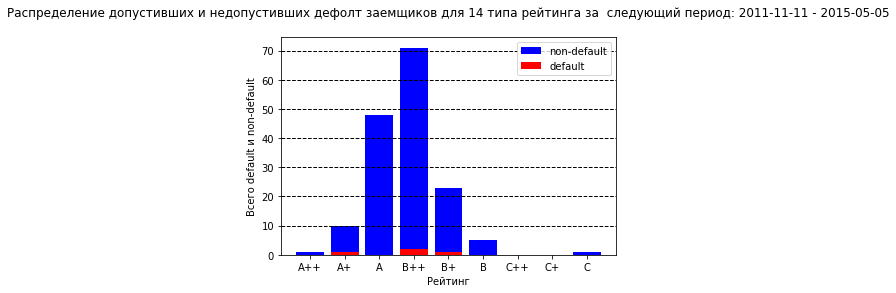

In [6]:
# 1) Подсчитаем суммарное количество дефолтеров и недефолтеров для каждой рейтинговой категории:

result['total'] = result['default'] + result['non-default']

# 2) Импортируем пакет для построения графика:

import matplotlib.pyplot as plt

# 3) Выбираем данные, строим легенду и сетку, подписываем оси, а также даем графику название:

plt.bar(result.index, result['total'],color = 'blue')

plt.bar(result.index, result['default'],color = 'red')

plt.xlabel('Рейтинг')

plt.ylabel('Всего default и non-default')

plt.legend(['non-default','default'])

plt.grid(axis='y', color='black', linestyle='--', linewidth=1)

plt.title('Распределение допустивших и недопустивших дефолт заемщиков для ' + str(rat_type) + ' типа рейтинга за  следующий период: ' + left_b + ' - ' + right_b + '\n')

# 4) Визуализируем график:

plt.show()

## Пункт 3. Построение кривой ROC (receiver operating characteristic):

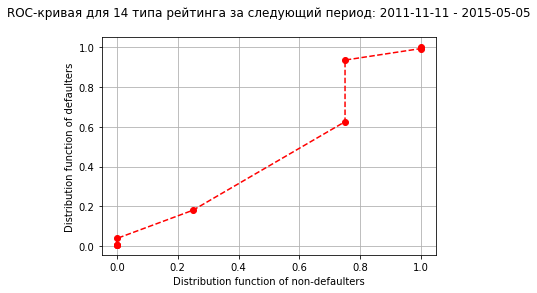

In [7]:
# 1) Напишем функцию для вычисления необходимых для построения ROC-кривой показателей:

def fun_roc(table):
    
    def_sum = table['default'].sum()
    
    non_def_sum = table['non-default'].sum()
    
    index = [0, 1, 2, 3, 4, 5, 6, 7, 8]
    
    table.index = index

    var1 = 0
    
    var2 = 0
    
    list1 = []
    
    list2 = []
    
    for i in range (8, -1, -1):

        var1 = table.iloc[i]['default'] + var1
        
        var2 = table.iloc[i]['non-default'] + var2

        if def_sum != 0:
            
            var3 = var1/def_sum
            
        else:
            
            var3 = 0
            
        if non_def_sum != 0:
            
            var4 = var2/non_def_sum
            
        else:
            
            var4 = 0
            
        list1.append(var3)
        
        list2.append(var4)
        
    return list1, list2

# 2) Воспользуемся написанной функцией:

roc1, roc2 = fun_roc(result)

# 3) Построим и визуализируем нужный график:

plt.title('ROC-кривая для ' + str(rat_type) + ' типа рейтинга за следующий период: ' + left_b + ' - ' + right_b + '\n')

plt.plot(roc1, roc2, marker = 'o', color = 'r', linestyle='--')

plt.xlabel('Distribution function of non-defaulters')

plt.ylabel('Distribution function of defaulters')

plt.grid()

plt.show()

# ДЗ №4. Кредитные рейтинги

## Пункт 1. Экспорт полученного ранее графика или таблицы (на выбор)

Укажите, что нужно экспортировать, график ROC-кривой - 0 или таблицу результатов распределения дефолтеров
и недефолтеров - 1: 0
Укажите путь к папке, в которую будет сохранен график (например: C:/Users/Public/IT4F/): C:/Users/Public/IT4F/
Укажите имя создаваемого графика: 


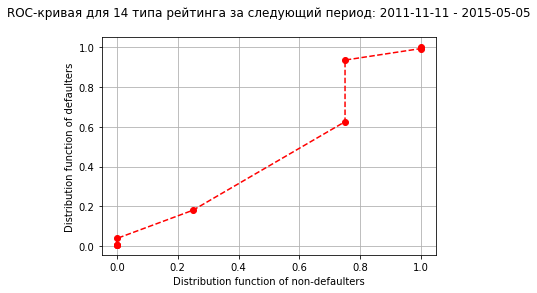

In [8]:
# 1) Запрашиваем у пользователя входные данные:

choice = int(input('''Укажите, что нужно экспортировать, график ROC-кривой - 0 или таблицу результатов распределения дефолтеров
и недефолтеров - 1: '''))

# 2) Составим алгоритм для экспорта таблицы или графика со всеми необходимыми параметрами:

if choice == 0:
    
    folder = input('Укажите путь к папке, в которую будет сохранен график (например: C:/Users/Public/IT4F/): ')
    
    name = input('Укажите имя создаваемого графика: ')
    
    if name == '':
        
        name = 'ROC-curve'
    
    plt.title('ROC-кривая для ' + str(rat_type) + ' типа рейтинга за следующий период: ' + left_b + ' - ' + right_b + '\n')

    plt.plot(roc1, roc2, marker = 'o', color = 'r', linestyle='--')

    plt.xlabel('Distribution function of non-defaulters')

    plt.ylabel('Distribution function of defaulters')

    plt.grid()
    
    plt.savefig(folder + name + '.png', dpi = 100)
    
else:
    
    folder = input('Укажите путь к папке, в которую будет сохранена таблица (например: C:/Users/Public/IT4F/): ')
    
    name = input('Укажите имя создаваемой таблицы: ')
    
    if name == '':
        
        name = 'Def_or_non_table'
   
    result.to_csv(folder + name + '.csv')

## Пункт 2. Автоматическая генерация отчета о результатах расчетов в PDF

In [9]:
# 1) Последовательо по пунктам проведем подготовительные работы для генерации отчета:

# 1.1) Выполняем в Anaconda Prompt по очереди следующие команды:

# pip install jinja2

# pip install weasyprint

# pip install --upgrade pip setuptools

# 1.2) Переходим по ссылке, скачиваем и устаналиваем программу с настройками по умолчанию:

# https://github.com/tschoonj/GTK-for-Windows-Runtime-Environment-Installer/releases/download/2019-11-07/gtk3-runtime-3.24.12-2019-11-07-ts-win64.exe

# 1.3) Выполняем в Anaconda Prompt по очереди следующие команды:

# SET PROPER_GTK_FOLDER='C:\Program Files\GTK3-Runtime Win64\bin'

# SET PATH=%PROPER_GTK_FOLDER%;%PATH%

# PATH (на данном этапе нам необходимо убедиться, что добавленная директория появилась в списке)

# 1.4) Перезапускаем Jupyter и импортируем необходимые ресурсы:

from __future__ import print_function

from jinja2 import Environment, FileSystemLoader

from weasyprint import HTML, Document

import os

# 1.5) Скачиваем шаблон "myreport.html" в папке seminars на GitHub, помещаем его в рабочую директорию и создаем отчет:

envi = Environment(loader=FileSystemLoader('.'))

template = envi.get_template("myreport.html")

template_vars = {"title": "Отчет составлен Абакумовой Натальей",
                "INTRO": "Отчет несет в себе информацию о распределении компаний на допустивших и недопустивших дефолт для " + str(rat_type) + " типа рейтинга за следующий период: " + left_b + " - " + right_b, 
                 "TABLE_DESC": "Таблица несет в себе информацию о распределении компаний на допустивших и недопустивших дефолт для " + str(rat_type) + " типа рейтинга за следующий период: " + left_b + " - " + right_b, 
                 "TABLE": result.to_html(), 
                 "IMAGE_DESC": "На графике изображена ROC-кривая для " + str(rat_type) + " типа рейтинга за следующий период: " + left_b + " - " + right_b, 
                 "IMAGE": os.path.realpath(folder + name + '.png')
                }

report = input('Укажите имя отчета: ')

if report == '':
    
    report = 'Table_and_ROC'

rep_folder = input('Укажите путь к папке, в которую будет сохранен отчет (например: C:/Users/Public/IT4F/): ')
    
html_out = template.render(template_vars, presentational_hints=True)

HTML(string=html_out).write_pdf(rep_folder + report + '.pdf', presentational_hints=True)

Укажите имя отчета: 
Укажите путь к папке, в которую будет сохранен отчет (например: C:/Users/Public/IT4F/): C:/Users/Public/IT4F/
